In [10]:
import requests
import pandas as pd
from datetime import datetime
import time

# Configure the API
TOKEN = "YOUR TOKEN HERE"
STATION_ID = "GHCND:USW00094846"  # Chicago O'Hare
DATASET_ID = "GHCND"
UNITS = "standard"

HEADERS = {"token": TOKEN}
BASE_URL = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"

# Fetch the data
def get_noaa_data(year):
    """Fetch daily data for a given year with pagination"""
    all_records = []
    offset = 1
    limit = 1000

    params = {
        "datasetid": DATASET_ID,
        "stationid": STATION_ID,
        "startdate": f"{year}-01-01",
        "enddate": f"{year}-12-31",
        "units": UNITS,
        "limit": limit,
        "offset": offset,
    }

    while True:
        response = requests.get(BASE_URL, headers=HEADERS, params=params)
        if response.status_code != 200:
            print(f"Error {response.status_code}: {response.text}")
            break

        data = response.json()
        results = data.get("results", [])
        if not results:
            break

        all_records.extend(results)

        # Pagination
        if len(results) < limit:
            break
        params["offset"] += limit

        time.sleep(0.3)

    return all_records


# How much data to fetch
all_data = []
for year in [2023, 2024, 2025]:
    print(f"Fetching {year}...")
    records = get_noaa_data(year)
    print(f"  → {len(records)} records fetched for {year}")
    all_data.extend(records)

print(f"✅ Total records fetched: {len(all_data)}")

# Convert to Dataframes
if all_data:
    df = pd.DataFrame(all_data)
    df["date"] = pd.to_datetime(df["date"]).dt.date
    df_pivot = df.pivot_table(
        index="date", columns="datatype", values="value", aggfunc="mean"
    ).reset_index()

    print("✅ NOAA data shape:", df_pivot.shape)
    print(df_pivot.head())
else:
    print("⚠️ No data fetched — check your NOAA token or date range.")




Fetching 2023...
Error 503: <!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>503 Service Unavailable</title>
</head><body>
<h1>Service Unavailable</h1>
<p>The server is temporarily unable to service your
request due to maintenance downtime or capacity
problems. Please try again later.</p>
<p>Additionally, a 503 Service Unavailable
error was encountered while trying to use an ErrorDocument to handle the request.</p>
</body></html>

  → 3000 records fetched for 2023
Fetching 2024...
  → 6872 records fetched for 2024
Fetching 2025...
  → 3147 records fetched for 2025
✅ Total records fetched: 13019
✅ NOAA data shape: (832, 29)
datatype        date  ADPT     ASLP    ASTP  AWBT  AWND  PGTM  PRCP  RHAV  \
0         2023-01-01  28.0  10139.0  9892.0  39.0   3.8   NaN  0.16  88.0   
1         2023-01-02  11.0  10163.0  9909.0  22.0   6.5   NaN  0.00  86.0   
2         2023-01-03  44.0  10041.0  9787.0  50.0   7.6   NaN  1.12  91.0   
3         2023-01-04  -6.0  10071.0  98

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Without fetching the API

In [14]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Chicago-Jan-01-2023_to_Aug-31-2025.csv")
print("Initial shape:", df.shape)

# Check Missing Values for further cleaning
print("\nColumns:\n", df.columns.tolist())
print("\nMissing values (top 10):\n", df.isna().sum().sort_values(ascending=False).head(10))

# Standardize datetime
if "datetime" in df.columns:
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
    df = df.dropna(subset=["datetime"])
else:
    raise ValueError("No 'datetime' column found — please check file structure")

# Handle missing or irrelevant columns
drop_cols = [
    "stations", "description", "icon", "name"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Fill missing numeric values with interpolation (smooth time-series)
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].interpolate(method="linear", limit_direction="both")

# Fill categorical text columns with mode (most frequent value)
cat_cols = df.select_dtypes(exclude=[np.number]).columns
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode()[0] if not df[c].mode().empty else "Unknown")

df["month"] = df["datetime"].dt.month
df["year"] = df["datetime"].dt.year
df["dayofweek"] = df["datetime"].dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5, 6])

print("\n✅ Cleaned Data Summary:")
print(df.info())
print("\nPreview:")
print(df.head())

# df.to_csv("/content/drive/MyDrive/Colab Notebooks/Chicago_weather_cleaned.csv", index=False)
# print("\n💾 Cleaned dataset saved to /content/drive/MyDrive/Colab Notebooks/Chicago_weather_cleaned.csv")


Initial shape: (974, 33)

Columns:
 ['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise', 'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations']

Missing values (top 10):
 preciptype      577
severerisk      102
name              0
tempmin           0
datetime          0
feelslikemax      0
feelslikemin      0
feelslike         0
tempmax           0
dew               0
dtype: int64

✅ Cleaned Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          974 non-null    datetime64[ns]
 1   tempmax      

EDA

In [22]:
weather = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Chicago_weather_cleaned.csv", parse_dates=["datetime"], infer_datetime_format=True)
print("shape:", weather.shape)
print(weather.dtypes)
print(weather.head())
# Missingness
miss = weather.isna().sum().sort_values(ascending=False)
print(miss[miss>0])
# Basic ranges
print(weather[['tempmax','tempmin','precip','windspeed']].describe())


shape: (974, 33)
datetime            datetime64[ns]
tempmax                    float64
tempmin                    float64
temp                       float64
feelslikemax               float64
feelslikemin               float64
feelslike                  float64
dew                        float64
humidity                   float64
precip                     float64
precipprob                   int64
precipcover                float64
preciptype                  object
snow                       float64
snowdepth                  float64
windgust                   float64
windspeed                  float64
winddir                    float64
sealevelpressure           float64
cloudcover                 float64
visibility                 float64
solarradiation             float64
solarenergy                float64
uvindex                      int64
severerisk                 float64
sunrise                     object
sunset                      object
moonphase                  float64
con

/tmp/ipython-input-1294447302.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  weather = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Chicago_weather_cleaned.csv", parse_dates=["datetime"], infer_datetime_format=True)


/tmp/ipython-input-3136144738.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weather.set_index('datetime')['tempmax'].isna().resample('M').mean().plot(title='Monthly % missing tempmax')


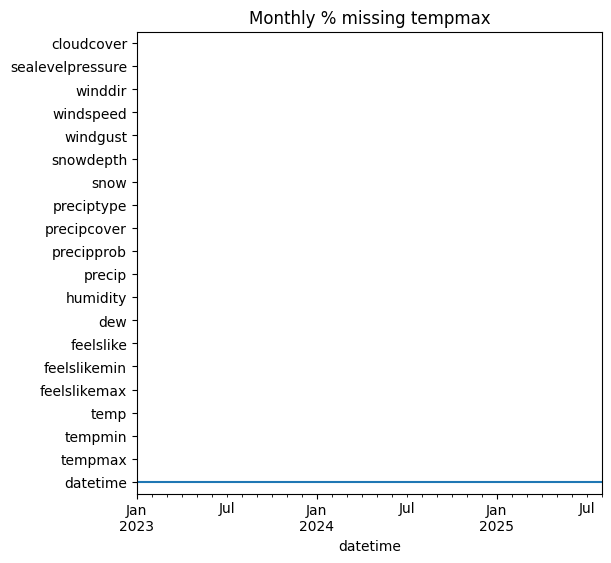

In [23]:
import matplotlib.pyplot as plt
# percent missing
pct = weather.isna().mean().sort_values(ascending=False)*100
pct.head(20).plot.barh(figsize=(6,6)); plt.title("Percent missing by column"); plt.xlabel("% missing")
# time-based missingness (per month)
weather.set_index('datetime')['tempmax'].isna().resample('M').mean().plot(title='Monthly % missing tempmax')
plt.show()

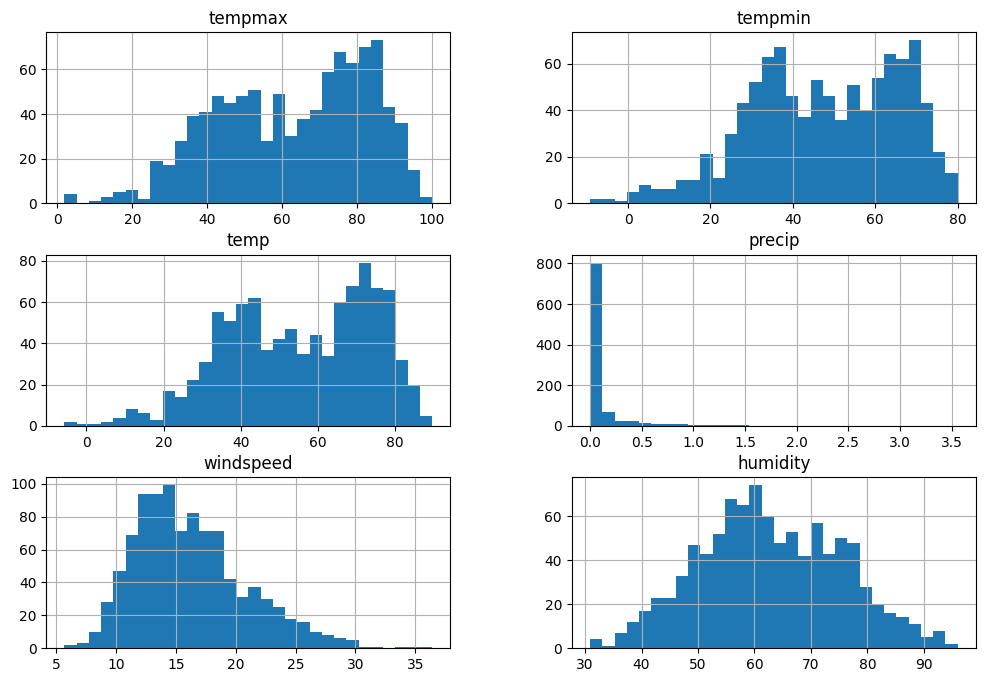

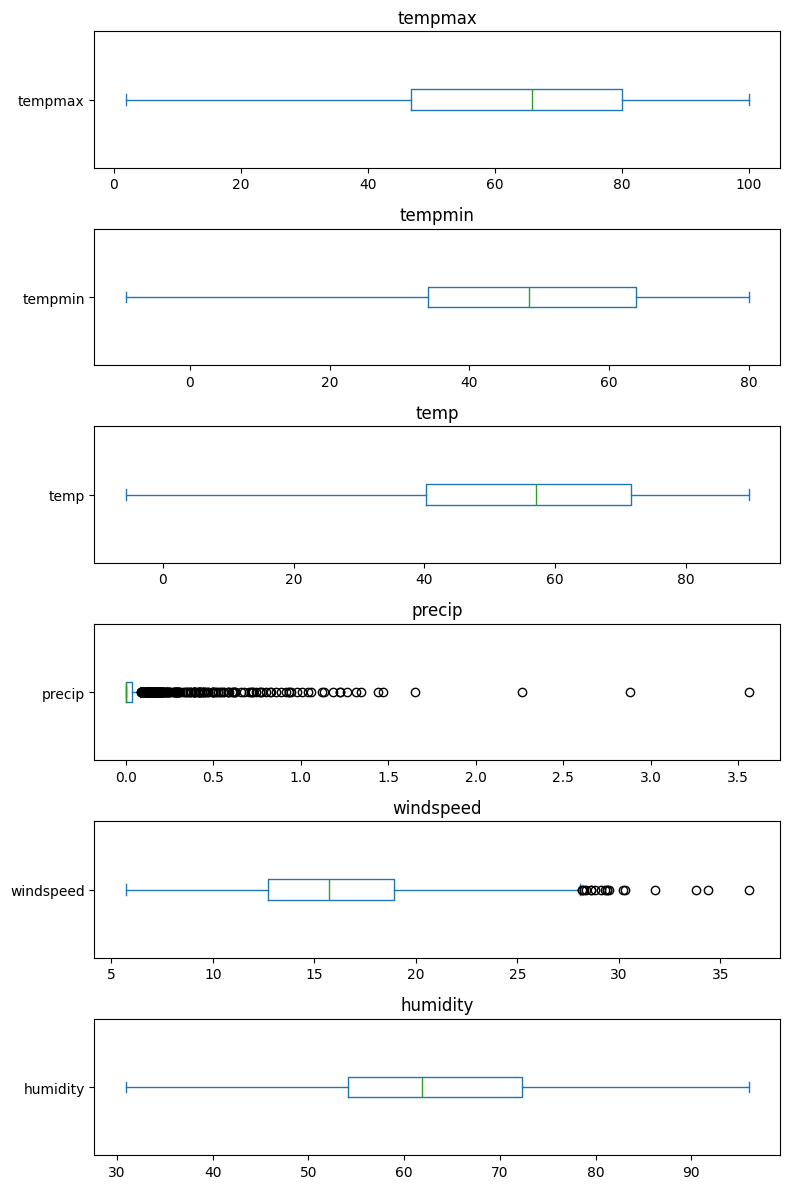

In [24]:
cols = ['tempmax','tempmin','temp','precip','windspeed','humidity']
weather[cols].hist(bins=30, figsize=(12,8))
plt.show()

# Boxplots to identify extreme outliers
fig, ax = plt.subplots(len(cols),1, figsize=(8,12))
for i,c in enumerate(cols):
    weather[c].plot.box(ax=ax[i], vert=False); ax[i].set_title(c)
plt.tight_layout(); plt.show()

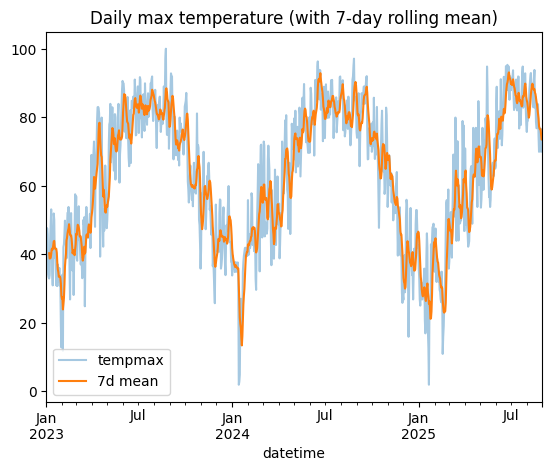

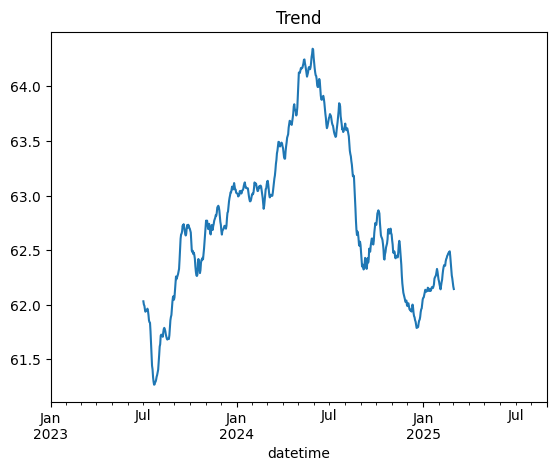

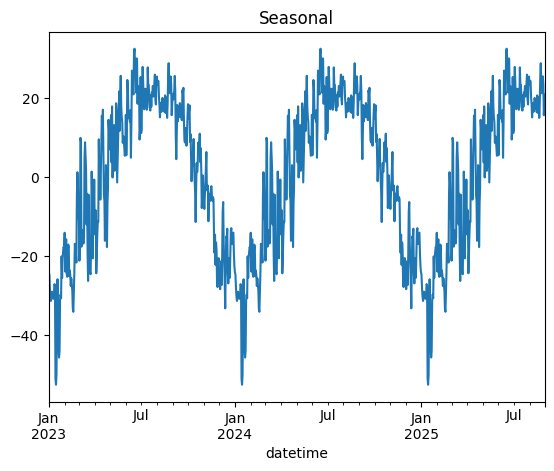

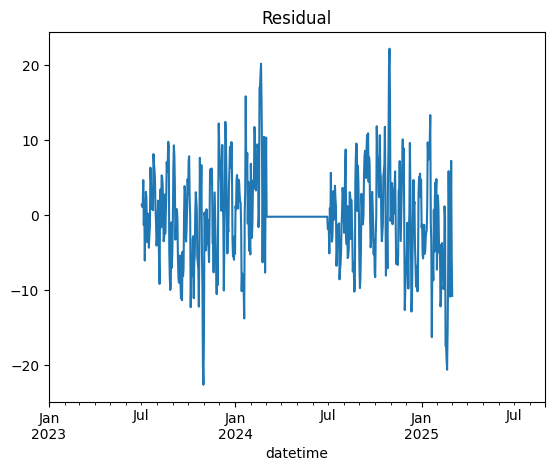

In [25]:
# daily plot + 7-day rolling mean
weather = weather.sort_values('datetime').set_index('datetime')
weather['tempmax'].plot(alpha=0.4, label='tempmax'); weather['tempmax'].rolling(7).mean().plot(label='7d mean')
plt.legend(); plt.title('Daily max temperature (with 7-day rolling mean)')
plt.show()

# Seasonal decomposition (requires statsmodels)
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(weather['tempmax'].dropna(), model='additive', period=365)
res.trend.plot(title='Trend'); plt.show()
res.seasonal.plot(title='Seasonal'); plt.show()
res.resid.plot(title='Residual'); plt.show()

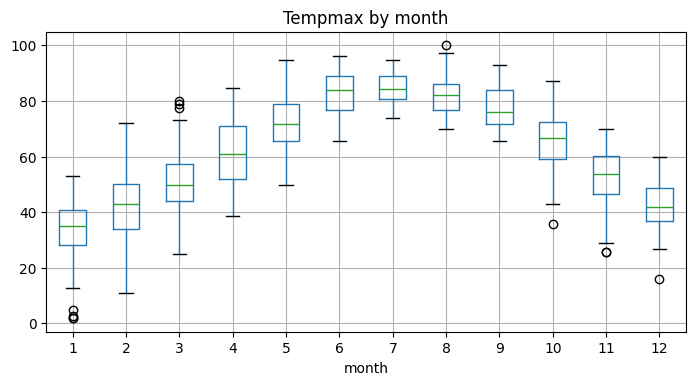

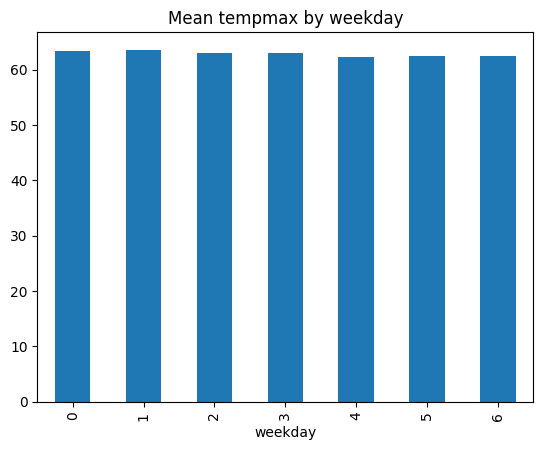

In [26]:
weather['month'] = weather.index.month
weather['weekday'] = weather.index.dayofweek
# boxplot by month
weather.boxplot(column='tempmax', by='month', figsize=(8,4))
plt.title('Tempmax by month'); plt.suptitle(''); plt.show()

# weekday-hour pattern for hourly data (if you have hourly)
# example for daily: mean temp by weekday
weather.groupby('weekday')['tempmax'].mean().plot(kind='bar')
plt.title('Mean tempmax by weekday'); plt.show()